# Setup

In [55]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import Adam

# --- 1. MEMUAT DATA DAN PRE-PROCESSING ---

In [ ]:
# Ganti path file Anda
df = pd.read_csv("tweet_bersih.csv")

# 1. Mengambil Teks dan Label
X = df['tweet_bersih']
y = df['sentimen']

# 2. Encoding Label
encoder = {'negatif':0, 'netral':1, 'positif':2}
y_encode = y.map(encoder)
y_labels = y_encode.values # Label numerik (numpy array)
X_list = X.astype(str).tolist() # Mengubah semua nilai menjadi string secara eksplisit

# --- 2. KONFIGURASI DAN TOKENISASI INDOBERT ---

In [57]:
MODEL_NAME = "indobenchmark/indobert-base-p1"
MAX_LEN_BERT = 35 
RANDOM_STATE = 16

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenisasi Data
encoded_data = tokenizer.batch_encode_plus(
    X_list,
    add_special_tokens=True,      
    return_attention_mask=True,   
    padding='max_length',         
    truncation=True,              
    max_length=MAX_LEN_BERT,
    return_tensors='pt'           # PyTorch Tensors
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(y_labels) # Konversi label ke PyTorch Tensor

# --- 3. DATA SPLITTING DAN DATALOADER ---

In [58]:
# Membagi data menjadi train/test (dengan random_state=16)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    input_ids, labels, test_size=0.2, random_state=RANDOM_STATE
)
mask_train, mask_test, _, _ = train_test_split(
    attention_masks, labels, test_size=0.2, random_state=RANDOM_STATE
)

BATCH_SIZE = 8

train_data = TensorDataset(X_train_t, mask_train, y_train_t)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)

test_data = TensorDataset(X_test_t, mask_test, y_test_t)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

# Tentukan device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 4. MODEL LOADING DAN OPTIMIZER INITIATION (PERBAIKAN KRITIS) ---

In [59]:
# Harus diinisialisasi di sini sebelum digunakan oleh optimizer
model_bert = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3 
)
model_bert.to(device) # Pindahkan model ke device

# Hyperparameters
EPOCHS = 4
LR_BERT = 2e-6

# Optimizer dan Scheduler
# Sekarang model_bert sudah didefinisikan
optimizer = Adam(model_bert.parameters(), lr=LR_BERT, eps=1e-9) 
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# --- 5. FUNGSI PELATIHAN DAN EVALUASI ---

In [60]:
# --- 5. FUNGSI PELATIHAN DAN EVALUASI (PERBAIKAN FINAL) ---
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    y_true_list = []
    y_pred_list = []

    for step, batch in enumerate(dataloader):
        batch = [r.to(device) for r in batch]
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs.loss
        total_loss += loss.item()
        
        # --- Bagian yang ditambahkan untuk menghitung akurasi ---
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        y_true_list.extend(label_ids.flatten())
        y_pred_list.extend(np.argmax(logits, axis=1).flatten())
        # --------------------------------------------------------

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
    avg_loss = total_loss / len(dataloader)
    accuracy = np.sum(np.array(y_pred_list) == np.array(y_true_list)) / len(y_true_list)
    
    # Pastikan mengembalikan DUA nilai: loss dan akurasi
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    model.eval()
    y_true_list = []
    y_pred_list = []
    
    for batch in dataloader:
        batch = [t.to(device) for t in batch]
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        y_true_list.extend(label_ids.flatten())
        y_pred_list.extend(np.argmax(logits, axis=1).flatten())
        
    accuracy = np.sum(np.array(y_pred_list) == np.array(y_true_list)) / len(y_true_list)
    
    return accuracy, np.array(y_true_list), np.array(y_pred_list)

# --- 6. JALANKAN TRAINING ---

In [61]:
training_stats = []
best_test_accuracy = 0
patience_counter = 0
PATIENCE = 1
best_epoch = 0
best_train_accuracy = 0
best_loss = float('inf')

print("Mulai Fine-Tuning IndoBERT...")
target_names = ['negatif', 'netral', 'positif']

for epoch_i in range(0, EPOCHS):
    print(f'\n======== Epoch {epoch_i + 1} / {EPOCHS} ========')

    # Training
    avg_train_loss, train_accuracy = train_epoch(model_bert, train_dataloader, optimizer, scheduler, device)

    # Evaluation
    test_accuracy, y_true, y_pred = evaluate(model_bert, test_dataloader, device)

    print(f"  Avg Training Loss: {avg_train_loss:.4f}")
    print(f"  Train Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")

    # --- LOGIKA EARLY STOPPING ---
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_epoch = epoch_i + 1
        best_train_accuracy = train_accuracy
        best_loss = avg_train_loss
        patience_counter = 0

        best_y_true = y_true
        best_y_pred = y_pred

        print("  Model Saved! (New Best)")
    else:
        patience_counter += 1
        print(f"  Accuracy not improved. Patience: {patience_counter}/{PATIENCE}")

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy
        }
    )

    if patience_counter >= PATIENCE:
        print("\n*** EARLY STOPPING: Akurasi Test tidak meningkat. Menghentikan pelatihan. ***")
        break

Mulai Fine-Tuning IndoBERT...

======== Epoch 1 / 4 ========
  Avg Training Loss: 1.0028
  Train Accuracy: 0.4945
  Test Accuracy: 0.5895
  Model Saved! (New Best)

======== Epoch 2 / 4 ========
  Avg Training Loss: 0.8611
  Train Accuracy: 0.6205
  Test Accuracy: 0.6391
  Model Saved! (New Best)

======== Epoch 3 / 4 ========
  Avg Training Loss: 0.8060
  Train Accuracy: 0.6543
  Test Accuracy: 0.6446
  Model Saved! (New Best)

======== Epoch 4 / 4 ========
  Avg Training Loss: 0.7677
  Train Accuracy: 0.6777
  Test Accuracy: 0.6419
  Accuracy not improved. Patience: 1/1

*** EARLY STOPPING: Akurasi Test tidak meningkat. Menghentikan pelatihan. ***


# --- 7. EVALUASI AKHIR DETAILED ---

In [62]:
df_stats = pd.DataFrame(data=training_stats)

print("\n" + "="*50)
print(f"| HASIL AKHIR INDOBERT (EPOCH {best_epoch}) |")
print("="*50)
print(f"Akurasi Training: {best_train_accuracy:.4f}")
print(f"Akurasi Test: {best_test_accuracy:.4f}\n")

# Laporan Klasifikasi
print(classification_report(best_y_true, best_y_pred, target_names=target_names))


| HASIL AKHIR INDOBERT (EPOCH 3) |
Akurasi Training: 0.6543
Akurasi Test: 0.6446

              precision    recall  f1-score   support

     negatif       0.63      0.64      0.63       116
      netral       0.65      0.75      0.70       124
     positif       0.65      0.54      0.59       123

    accuracy                           0.64       363
   macro avg       0.64      0.64      0.64       363
weighted avg       0.64      0.64      0.64       363



## 7.1. Visualisasi Kurva Loss dan Akurasi

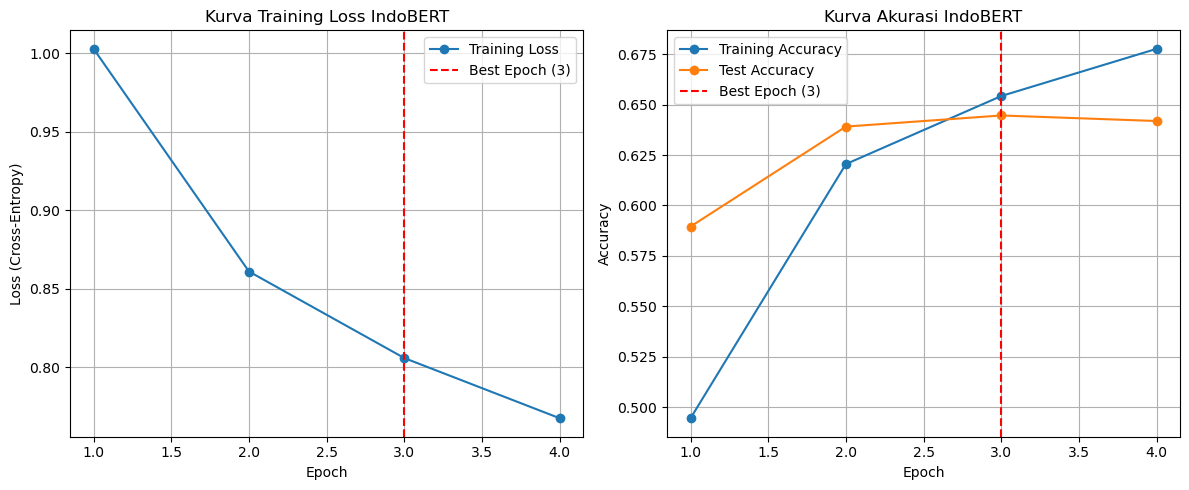

In [63]:
plt.figure(figsize=(12, 5))

# Plot 1: Kurva Loss
plt.subplot(1, 2, 1)
plt.plot(df_stats['epoch'], df_stats['Training Loss'], marker='o', label='Training Loss')
plt.title('Kurva Training Loss IndoBERT')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross-Entropy)')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.legend()
plt.grid(True)

# Plot 2: Kurva Akurasi
plt.subplot(1, 2, 2)
plt.plot(df_stats['epoch'], df_stats['Train Accuracy'], marker='o', label='Training Accuracy')
plt.plot(df_stats['epoch'], df_stats['Test Accuracy'], marker='o', label='Test Accuracy')
plt.title('Kurva Akurasi IndoBERT')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 7.2. Visualisasi Confusion Matrix

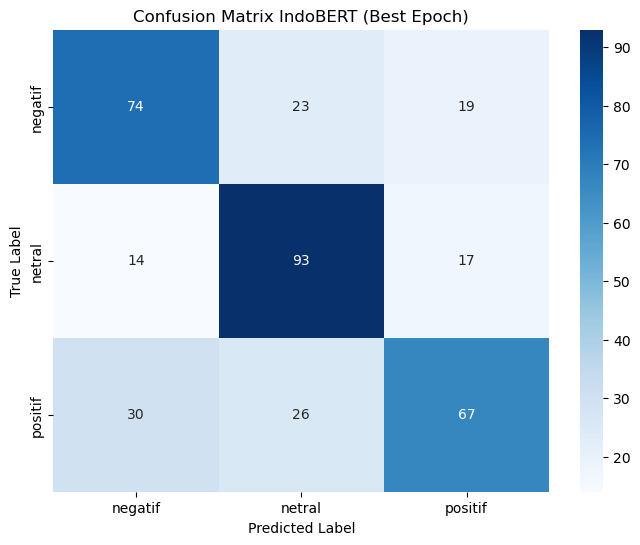

In [64]:
cm = confusion_matrix(best_y_true, best_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix IndoBERT (Best Epoch)')
plt.show()